In [19]:
import pystencils as ps
import numpy as np
import sympy as sp
from pystencils import plot as plt
import psutil
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
import matplotlib.animation as animation
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling
from pystencils.slicing import slice_from_direction
import math
import time
%matplotlib inline

In [20]:
grid_points = 257
dh = ps.create_data_handling(domain_size=(grid_points, 1), periodicity=True)  # able to organize data on 256x256 lattice
μ_field = dh.add_array('mu', latex_name='μ', ghost_layers=2)  # chemical potential (functional derivative of free energy)
c_field = dh.add_array('c', ghost_layers=2)  # raw concentration that free energy depends on

In [21]:
ε = sp.symbols("ε")

c = c_field.center
μ = μ_field.center

def f(c):
    return -ε*c**2/2 + c**4/4

bulk_free_energy_density = f(c)

covariant_free_energy_density = 1/2 * c**2

grad_sq = sum(ps.fd.diff(c, i)**2 for i in range(dh.dim))
interfacial_free_energy_density = -grad_sq

grad_fourth = sum(ps.fd.diff(ps.fd.diff(c, i), i)**2 for i in range(dh.dim)) + 2*ps.fd.diff(ps.fd.diff(c, 0), 0)*ps.fd.diff(ps.fd.diff(c, 1), 1)
interface_deformation_free_energy_density = 1/2 * grad_fourth

free_energy_density = bulk_free_energy_density + covariant_free_energy_density + interfacial_free_energy_density + interface_deformation_free_energy_density
free_energy_density

c_C**4/4 - c_C**2*ε/2 + 0.5*c_C**2 - Diff(c_C, 0, -1)**2 - Diff(c_C, 1, -1)**2 + 0.5*Diff(Diff(c_C, 0, -1), 0, -1)**2 + 1.0*Diff(Diff(c_C, 0, -1), 0, -1)*Diff(Diff(c_C, 1, -1), 1, -1) + 0.5*Diff(Diff(c_C, 1, -1), 1, -1)**2

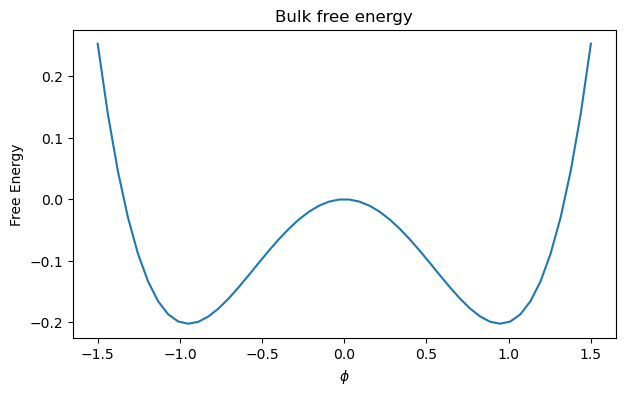

In [22]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(ε, 0.9), (-1.5, 1.5))
plt.xlabel(r"$\phi$")
plt.ylabel("Free Energy")
plt.title("Bulk free energy");
plt.savefig('Symmetrized energy.jpg', dpi = 800)
plt.show()

In [23]:
# here we manually write the update equation for chemical potential μ because 
# Pystencils functional derivative method cannot handle mixed partial derivatives
def bulk_deriv(c):
    return -ε*c + c**3

μ_bulk = bulk_deriv(c)

μ_covariant = c

laplacian = sum(ps.fd.diff(c, i, i) for i in range(dh.dim))
μ_interfacial = 2*laplacian

grad_fourth = sum(ps.fd.diff(c, i, i, i, i) for i in range(dh.dim)) + 2*ps.fd.diff(c, 1, 1, 0, 0)
μ_interface_deformation = grad_fourth

μ_update_eq = μ_bulk + μ_covariant + μ_interfacial + μ_interface_deformation

μ_update_eq

c_C**3 - c_C*ε + c_C + 2*Diff(Diff(c_C, 0, -1), 0, -1) + 2*Diff(Diff(c_C, 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 0, -1), 0, -1) + 2*Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 1, -1), 1, -1), 1, -1), 1, -1)

In [125]:
'''
It turns out the inbuilt discretization functions neither work for above 2nd order differential equations...
Let's do this part by hand too, and hope it works.
'''
epsilon = 0.1
natural_period = 2*np.pi
one_sixteenth_period = 1/16*natural_period
total_domain_length = (grid_points-1)*one_sixteenth_period
domain_points = np .linspace(0, total_domain_length, num = grid_points)
time_discretization = 2*10**(-5)

Δx, Δt = sp.symbols("Δx Δt")

discretize_2ndorderPDEs = ps.fd.Discretization2ndOrder(dx=one_sixteenth_period, dt=time_discretization)

μ_interfacial_discretized = discretize_2ndorderPDEs(μ_interfacial)

μ_interfacial_discretized

-51.8764460248769*c_C + 12.9691115062192*c_E + 12.9691115062192*c_N + 12.9691115062192*c_S + 12.9691115062192*c_W

In [126]:
#we must recursively leverage the in-built function for discretizing 2nd order PDEs in order to discretize our 4th order one
second_grad_0 = ps.fd.diff(c,0,0)
second_grad_1 = ps.fd.diff(c,1,1)

second_grad_0_discretized = discretize_2ndorderPDEs(second_grad_0)
second_grad_1_discretized = discretize_2ndorderPDEs(second_grad_1)

fourth_grad_0 = ps.fd.diff(second_grad_0_discretized,0,0)
fourth_grad_0 = ps.fd.expand_diff_linear(fourth_grad_0)
fourth_grad_1 = ps.fd.diff(second_grad_1_discretized,1,1)
fourth_grad_1 = ps.fd.expand_diff_linear(fourth_grad_1)

fourth_grad_0_discretized = discretize_2ndorderPDEs(fourth_grad_0)
fourth_grad_1_discretized = discretize_2ndorderPDEs(fourth_grad_1)


fourth_grad_mixed = ps.fd.diff(second_grad_0_discretized,1,1)
fourth_grad_mixed = ps.fd.expand_diff_linear(fourth_grad_mixed)


fourth_grad_mixed_discretized = 2*discretize_2ndorderPDEs(fourth_grad_mixed)


μ_interface_deformation_discretized = fourth_grad_0_discretized + fourth_grad_1_discretized + fourth_grad_mixed_discretized
μ_interface_deformation_discretized = ps.fd.expand_diff_linear(μ_interface_deformation_discretized)
μ_interface_deformation_discretized

42.049463315187*c_2E + 42.049463315187*c_2N + 42.049463315187*c_2S + 42.049463315187*c_2W + 840.989266303741*c_C - 336.395706521496*c_E - 336.395706521496*c_N + 84.0989266303741*c_NE + 84.0989266303741*c_NW - 336.395706521496*c_S + 84.0989266303741*c_SE + 84.0989266303741*c_SW - 336.395706521496*c_W

In [127]:
μ_update_eq_discretized = μ_bulk + μ_covariant + μ_interfacial_discretized + μ_interface_deformation_discretized
μ_update_eq_discretized

42.049463315187*c_2E + 42.049463315187*c_2N + 42.049463315187*c_2S + 42.049463315187*c_2W + c_C**3 - c_C*ε + 790.112820278864*c_C - 323.426595015277*c_E - 323.426595015277*c_N + 84.0989266303741*c_NE + 84.0989266303741*c_NW - 323.426595015277*c_S + 84.0989266303741*c_SE + 84.0989266303741*c_SW - 323.426595015277*c_W

In [128]:

μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center,
                                           μ_update_eq_discretized.subs(ε, epsilon))]
                           ).compile()
# here we define the update function of the chemical potential BEFORE that of yhe concentration

In [129]:
M = sp.Symbol("M")
# after suffering through the defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that
conserved_swift_hohenberg = ps.fd.transient(c) - ps.fd.diffusion(μ, M)  # continuity equation! M is mobility (diffusion) coefficient
conserved_swift_hohenberg

-Diffusion(mu_C, M) + Transient(c_C)

In [130]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update = discretize_2ndorderPDEs(conserved_swift_hohenberg) 
c_update  # this is the symbolic rule of how c updates

c_C - 0.000518764460248769*mu_C*M + 0.000129691115062192*mu_E*M + 0.000129691115062192*mu_N*M + 0.000129691115062192*mu_S*M + 0.000129691115062192*mu_W*M

In [131]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update.subs(M, 1))]
                           ).compile()

In [132]:
dh.ghost_layers_of_field('c')

2

In [122]:
# no boundary functions because periodicity was already set in the data handler
def init(value=0.0, noise=0.02):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(value)
        np.add(b['c'], noise*(np.random.rand(*b['c'].shape)-1/2), out=b['c'])

In [107]:
def init_full_period(amp = 1/10, noise=0.005):
    # the values here are set default for epsilon = 0.9, as extracted from the literature phase diagram
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        
        # initialize the matrix that will be inserted into the concentration field later
        b['c'].fill(0)
        sinusoid = np.zeros(b['c'].shape)

        # define a sinusoid to initialize an already periodic domain
        # this quickens the simulation time to reach steady state
        domain_length = sinusoid.shape[0]        
        sinusoid_line = np.linspace(-2*one_sixteenth_period,(grid_points+1)*one_sixteenth_period,domain_length)
        sinusoid_line = amp*np.sin(sinusoid_line)

        
        for i in range(sinusoid.shape[1]):
            sinusoid[:,i] = sinusoid_line
        
        # finally, add noise on top of the system and place the result in the concentration field
        sinusoid = np.add(sinusoid, noise*(np.random.rand(*b['c'].shape)-1/2), out=sinusoid)
        np.add(b['c'], sinusoid, out=b['c'])
        
        print('Initialized avg phi:', np.mean(sinusoid[2:-2,2]))
        
        return np.mean(sinusoid[2:-2,2])

In [108]:
def init_mixed_preperiod(phi_uni=-0.675, phi_per=-0.243, avg_phi=-0.5, noise=0.005, amp = 1/10):
    # the values here are set default for epsilon = 0.9, as extracted from the literature phase diagram
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        
        # initialize the matrix that will be inserted into the concentration field later
        b['c'].fill(0)
        mixed = np.zeros(b['c'].shape)
        domain_length = mixed.shape[0]
        mixed_line = np.full(domain_length, phi_uni)
        
        # let's calculate the fraction of periodic phi INCLUDING the ghost layers from the avg phi that we desire in
        # the real system (excluding PBC ghost layers)
        system_frac_per = (avg_phi-phi_uni)/(phi_per-phi_uni)
        total_domain_frac_per = (domain_length-4)/domain_length*system_frac_per
        
        # initialize the part of the domain we consider to be inhabited by cellular
        cell_length = int((domain_length)*total_domain_frac_per)
        print('Cell length:', cell_length)
        cell_line = np.linspace(-(cell_length/2)*one_sixteenth_period,cell_length/2*one_sixteenth_period,cell_length)
        
        # define a sinusoid to initialize the periodic portion of the domain with some wave pattern
        # this quickens the simulation time to reach steady state
        sinusoid = amp*np.cos(2*np.pi/natural_period*cell_line)
        cell_line = sinusoid + phi_per - np.mean(sinusoid)  # maintain the average value
        
        # set the sinusoid in the center of the system to be the focus of the screen
        for i in range(cell_length):
            mixed_line[i+int((domain_length - cell_length)/2) + 1] = cell_line[i]
        for i in range(mixed.shape[1]):
            mixed[:,i] = mixed_line
        # finally, add noise on top of the system and place the result in the concentration field
        mixed = np.add(mixed, noise*(np.random.rand(*b['c'].shape)-1/2), out=mixed)
        np.add(b['c'], mixed, out=b['c'])
        
        print('Initialized avg phi:', np.mean(mixed[2:-2,2]))
        
        return np.mean(mixed[2:-2,2])

In [109]:
def init_from_memory(filename):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(0)
        init_memory = np.loadtxt(filename)
        np.add(b['c'], init_memory, out=b['c'])

In [110]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_kernel)  # followed by concentration dynamics from the chemical potential
    return dh.gather_array('c')

In [111]:
from matplotlib import animation

def animate(i):
    line.set_data(domain_points, full_evolution[i])
    if np.mean(full_evolution[i]) > 0:
        line.set_color('red')
    elif np.mean(full_evolution[i]) > -0.243:
        line.set_color('green')
        
def full_run(initialize_mixed=True, initialize_full=False, amp=1/10):
    start_time = time.perf_counter()
    
    if initialize_mixed:
        init_mixed_preperiod(avg_phi=average_phi,amp=amp)
        
    if initialize_full:
        init_full_period(amp=amp)
        average_phi = 0

        
        
    for i in range(total_frames):
        current_step = dh.cpu_arrays['c'][2:-2,2].copy()
        full_evolution[i,:] = current_step
        
        timeloop(steps=int(total_steps/total_frames))
        
        if i%(total_frames/total_snapshots) == 0:
            squares_of_differences[int(i/(total_frames/total_snapshots))] = np.mean((current_step - dh.cpu_arrays['c'][2:-2,2].copy())**2)
    
    
    end_time = time.perf_counter()        
    sim_time = end_time - start_time
    print("Sim time: ", sim_time)
    
    plt.plot(domain_points, full_evolution[0])
    plt.plot(domain_points, full_evolution[-1])
    plt.ylabel(r'$\phi$')
    plt.show()
    np.savetxt(r'Data to Compare to Literature\Steady' + f' phi={average_phi} amp={amp}.txt', full_evolution[-1])
    snapshots_times = np.linspace(0, time_discretization*(total_steps-1), total_snapshots)
    complete_snapshots = np.array([snapshots_times,squares_of_differences])
    np.savetxt(r'Steady State Snapshots\Snapshots' + f' phi={average_phi} amp={amp}.txt', complete_snapshots)
    

Initialized avg phi: -0.00011564249601915801
Sim time:  65.20798180000565


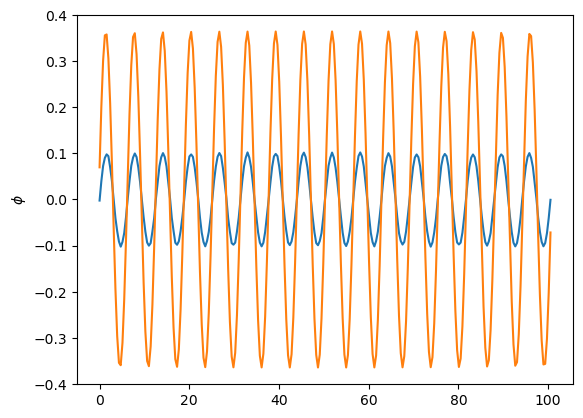

Text(0, 0.5, '$\\phi$')

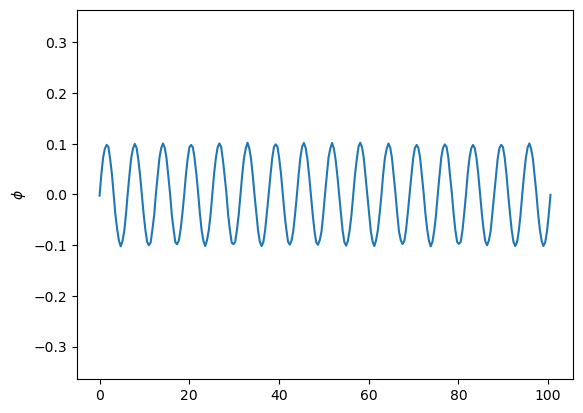

In [135]:
# in this cell we do a full run and subsequently save the animation

average_phi=-0.5
total_steps=3000000
total_frames=1000
total_snapshots = 200
full_evolution = np.zeros((total_frames, grid_points))
squares_of_differences = np.zeros((total_snapshots))
init_mixed = False
init_full = True
amp = 1/10

full_run(initialize_mixed=init_mixed,initialize_full=init_full,amp=amp)

fig,ax = plt.subplots()
line, = ax.plot(domain_points,full_evolution[0])
ax.set_ylim(np.min(full_evolution),np.max(full_evolution))
plt.ylabel(r'$\phi$')
    
#anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

#anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1D' + f' eps={epsilon} phi0={average_phi} amp={np.round(amp,3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))

In [85]:
# here we can save states to later initialize from

#np.savetxt('Initialization States\steady single cell 1024.txt', dh.cpu_arrays['c'])

In [136]:
np.savetxt(f'eps={epsilon} periodic.txt', dh.cpu_arrays['c'])

2.816168530804028e-05

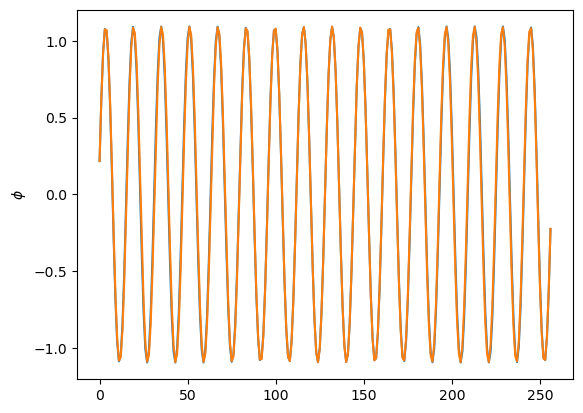

In [54]:
#here we can play with a run quickly to see if the dynamics look alright without preparing it for animation
avg_phi = -0.625

#init()
#init_mixed_preperiod(avg_phi = avg_phi, amp=1/20)
#init_full_period(amp=1/10)
c_arr = dh.cpu_arrays['c'][2:-2,2]
plt.plot(c_arr)
timeloop(steps=1000000)
plt.plot(c_arr)
plt.ylabel(r'$\phi$')
np.mean(c_arr)

In [126]:
hist, bin_edges = np.histogram(c_arr, bins=10)
bin_edges

array([-8.04845672e-01, -6.43819713e-01, -4.82793754e-01, -3.21767795e-01,
       -1.60741837e-01,  2.84122444e-04,  1.61310081e-01,  3.22336040e-01,
        4.83361999e-01,  6.44387958e-01,  8.05413917e-01])

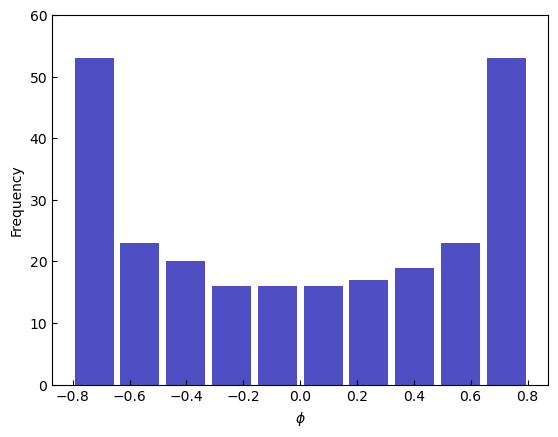

In [127]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=c_arr, bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
#plt.title('Phi Values in Mixed State')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.tick_params(direction="in")

### Here we extract digitized data from the literature to show that we have reproduced other researchers' results!
#### We also extract some of the data and use spline interpolation to see if we can find all the same steady state points.

In [168]:
from scipy.interpolate import make_interp_spline

def init_from_lit_data(filename, lit_avg_phi):
    for b in dh.iterate(ghost_layers=2):
        b['c'].fill(0)
        spline = np.zeros(b['c'].shape)
        domain_length = spline.shape[0]
        lit_data = np.loadtxt(filename)
        lit_data[:,0] = lit_data[:,0]*total_domain_length
        lit_data[:,1] = lit_data[:,1] + lit_avg_phi
        sorted_lit_data = lit_data[lit_data[:, 0].argsort()]
        spline_lit_data = make_interp_spline(sorted_lit_data[:,0], sorted_lit_data[:,1], k=1)
        spline_line = spline_lit_data(domain_points)
        for i in range(spline.shape[1]):
            spline[2:-2,i] = spline_line
            spline[0:2, i] = spline_line[0]
            spline[-2:0, i] = spline_line[-1]
        np.add(b['c'], spline, out=b['c'])

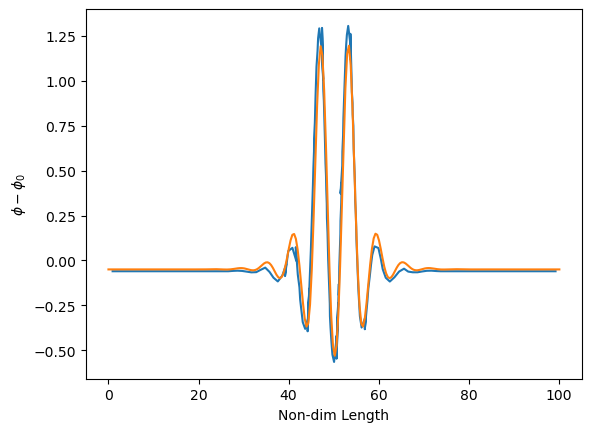

In [46]:
filename = '-0.625 even 2 tall peaks'
lit_data = np.loadtxt(r'Literature Data\Paper ' + filename + ' Dataset.txt')
lit_data[:,0] = lit_data[:,0]*total_domain_length
plt.plot(lit_data[:,0], lit_data[:,1])
plt.plot(domain_points, c_arr-avg_phi)
plt.xlabel('Non-dim Length')
plt.ylabel(r'$\phi - \phi_0$')
plt.savefig(r'Literature Comparisons\Compare ' + filename + '.jpg', dpi = 1200)

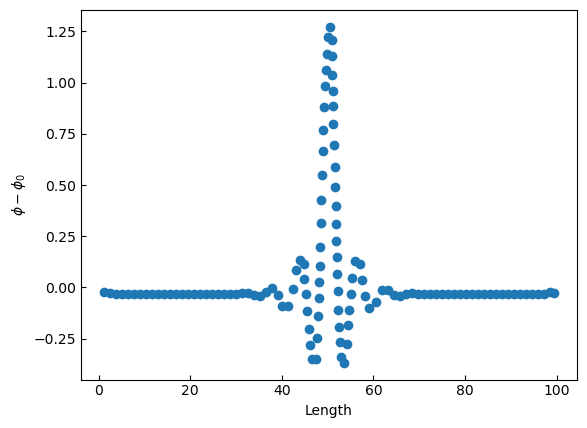

In [77]:
from scipy.interpolate import make_interp_spline

filename = '-0.625 odd 1 tall peak short sides'
lit_data = np.loadtxt(r'Literature Data\Paper ' + filename + ' Dataset.txt')
lit_data[:,0] = lit_data[:,0]*total_domain_length
sorted_lit_data = lit_data[lit_data[:, 0].argsort()]
#spline_lit_data = make_interp_spline(sorted_lit_data[:,0], sorted_lit_data[:,1], k=1)

plt.scatter(sorted_lit_data[:,0], sorted_lit_data[:,1])
#plt.plot(domain_points, spline_lit_data(domain_points), color = 'orange')
plt.xlabel('Length')
plt.ylabel(r'$\phi - \phi_0$')
plt.tick_params(direction="in")

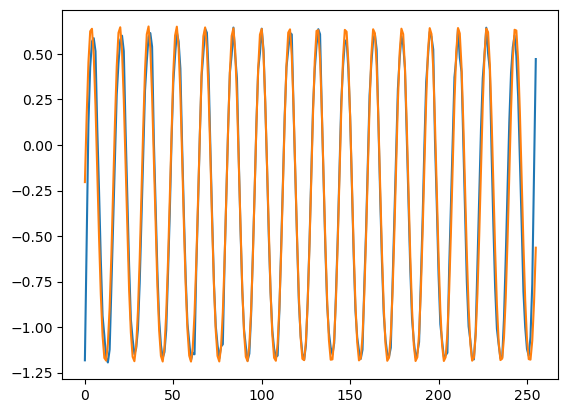

In [189]:
#here we take data directly from literature and place it into our field to compute

filename = '-0.3 full periodic'
literature_average_phi = -0.3
init_from_lit_data(r'Literature Data\Paper ' + filename + ' Dataset.txt', literature_average_phi)
c_arr = dh.cpu_arrays['c'][2:-2,2]
plt.plot(c_arr)
timeloop(steps=3000000)
plt.plot(c_arr)


In [134]:
filename = 'sorted -0.625 odd 1 tall peak short sides'
np.savetxt(r'Literature Data\Paper ' + filename + ' Dataset.txt', sorted_lit_data)


In [101]:
a = np.array([[4,3], [3,2], [5,1]])
a[:,0].sort(axis=0)
a

array([[3, 3],
       [4, 2],
       [5, 1]])

# Let's add growth!!

### By adding growth in the same notebook, we can immediately start growing from a relaxed steady state. Most importantly from a relaxed state of a single (layer of) cell.

In [86]:
#here we define the growth term and a new growth dynamical equation

g, M, W, C, S = sp.symbols("g M W C S")

def growth_term(c):
    return g*(sp.tanh(S*(c + W/2 - C))*sp.tanh(S*(W/2 + C - c)) + 1)

c_growth = growth_term(c)
# after suffering through defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that + our proposed growth term
swift_hohenberg_growth = ps.fd.transient(c) - ps.fd.diffusion(μ, M) - c_growth  # continuity equation! M is mobility (diffusion) coefficient
swift_hohenberg_growth



-g*(tanh(S*(-c_C + C + W/2))*tanh(S*(c_C - C + W/2)) + 1) - Diffusion(mu_C, M) + Transient(c_C)

In [87]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update_growth= discretize_2ndorderPDEs(swift_hohenberg_growth) 
c_update_growth  # this is the symbolic rule of how c updates

c_C - 0.000518764460248769*mu_C*M + 0.000129691115062192*mu_E*M + 0.000129691115062192*mu_N*M + 0.000129691115062192*mu_S*M + 0.000129691115062192*mu_W*M + 2.0e-5*g*tanh(S*(-2*c_C + 2*C + W)/2)*tanh(S*(2*c_C - 2*C + W)/2) + 2.0e-5*g

In [88]:
mobility=1
growth_factor=0.001
sigmoid=20
width=np.sqrt(epsilon)*9/10
center=np.sqrt(epsilon)/2

c_growth_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update_growth.subs(M, mobility).subs(g,growth_factor).subs(S,sigmoid).subs(W,width).subs(C,center))]
                           ).compile()


In [89]:
def timeloop_growth(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_growth_kernel)  # followed by concentration dynamics from the chemical potential, which now grow too
    return dh.gather_array('c')

In [90]:
from scipy.signal import find_peaks

def cell_growth(start_from_single_cell = True):
    start_time = time.perf_counter()
    
    if start_from_single_cell:
        init_from_memory(single_cell_filename)
    new_cell_step = []
    for i in range(total_frames):
        current_step = dh.cpu_arrays['c'][2:-2,2]
        if np.mean(current_step) > 0.243:
            break
        full_evolution[i,:] = current_step.copy()
        
        peaks = find_peaks(full_evolution[i,:], center-width/2)[0]
        if np.size(peaks) > 1 and np.size(np.where(full_evolution[i, peaks[0]:peaks[1]] < center-width/2)[0]) > 0 and len(new_cell_step) == 0:
            new_cell_step.append(i/total_frames*total_steps_growth)
        
        timeloop_growth(steps=int(total_steps_growth/total_frames))
        
    
    end_time = time.perf_counter()        
    sim_time = end_time - start_time
    print("Growth Sim time: ", sim_time)
    
    plt.plot(domain_points, full_evolution[-1])
    plt.ylabel(r'$\phi$')
    plt.show()
    if len(new_cell_step) > 0:
        return np.array(new_cell_step)[0]
    else:
        return 0

## Let's check qualitative behavior for a range of growth factors

In [94]:
#do we want to actually reset the new_cell_times list? only do it if you think you have bad data
new_cell_times = []
all_g_values = []

Growth Sim time:  672.7134555999655


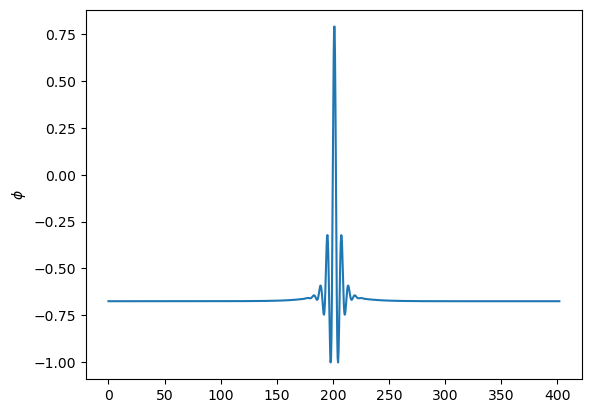

New Cell Time:  0.0
Growth Sim time:  661.8472855999134


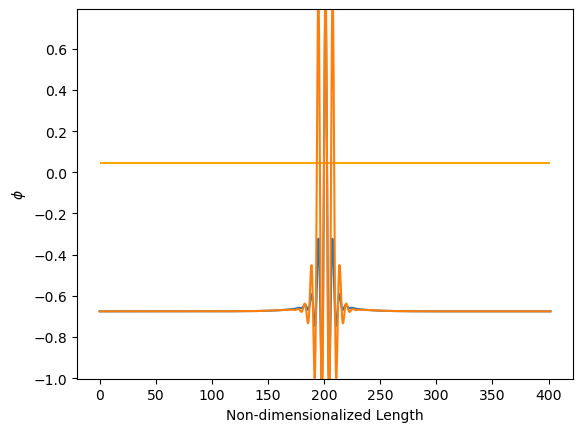

New Cell Time:  136.20000000000002
Growth Sim time:  667.3352691000327


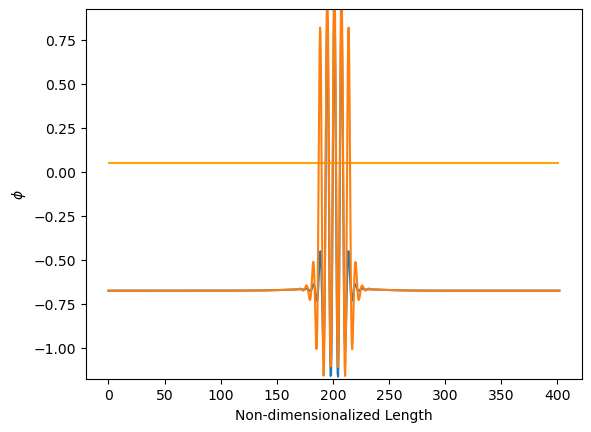

New Cell Time:  90.60000000000001
Growth Sim time:  669.767776099965


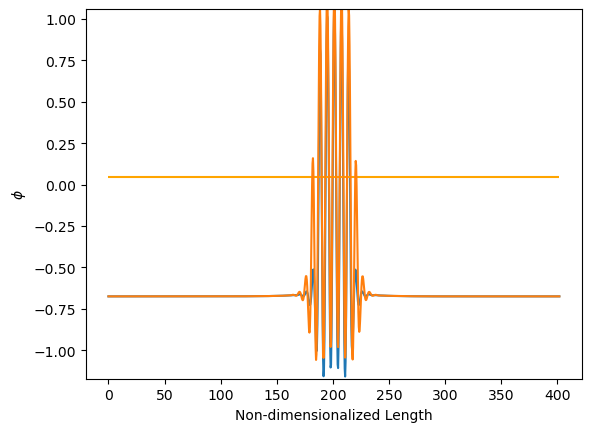

New Cell Time:  70.4
Growth Sim time:  666.3418040999677


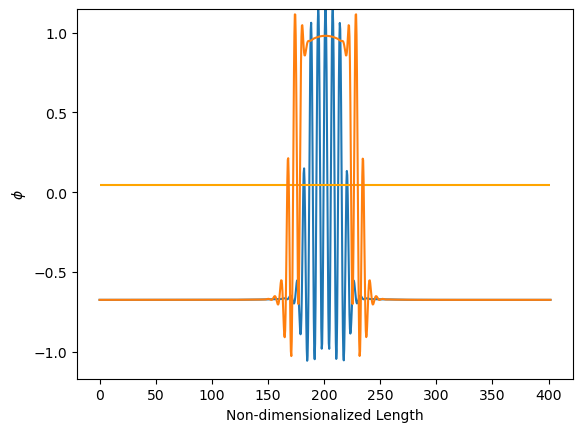

New Cell Time:  42.2
Growth Sim time:  666.0310242001433


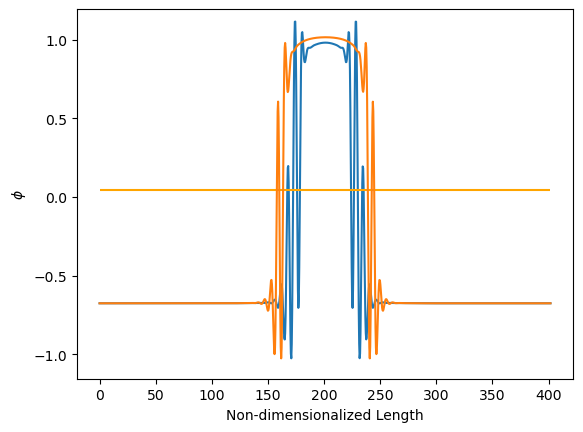

New Cell Time:  32.800000000000004
Growth Sim time:  662.330679600127


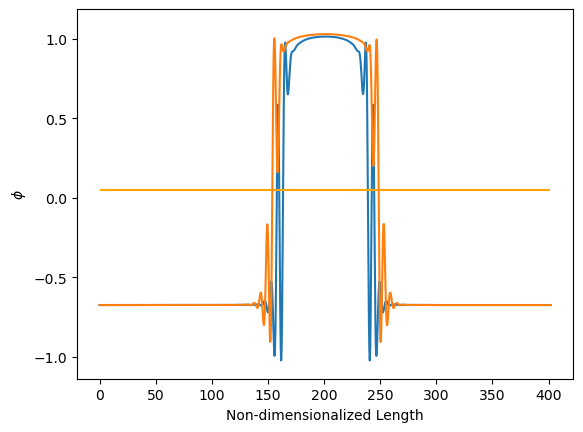

New Cell Time:  27.800000000000008
Growth Sim time:  672.8012280000839


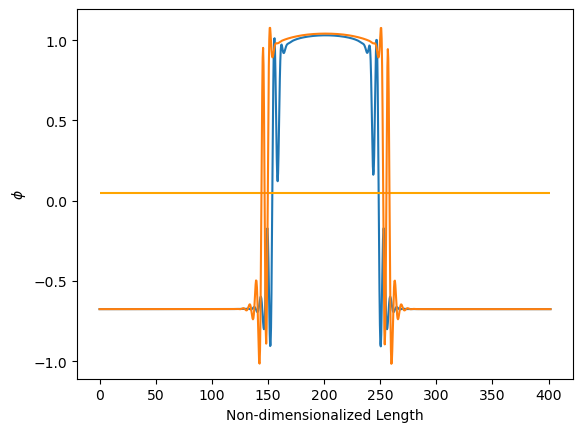

New Cell Time:  24.8
Growth Sim time:  719.0406578001566


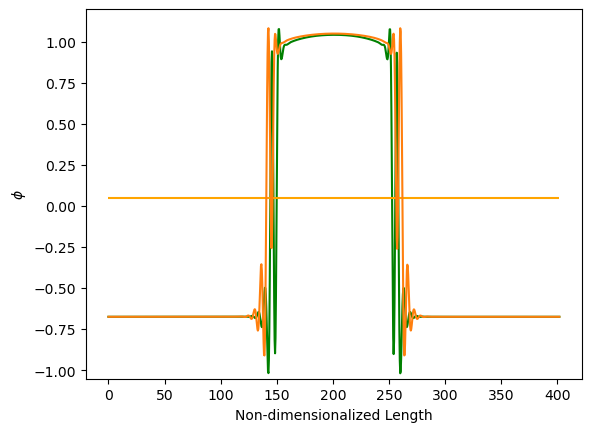

New Cell Time:  23.000000000000004
Growth Sim time:  738.8859748998657


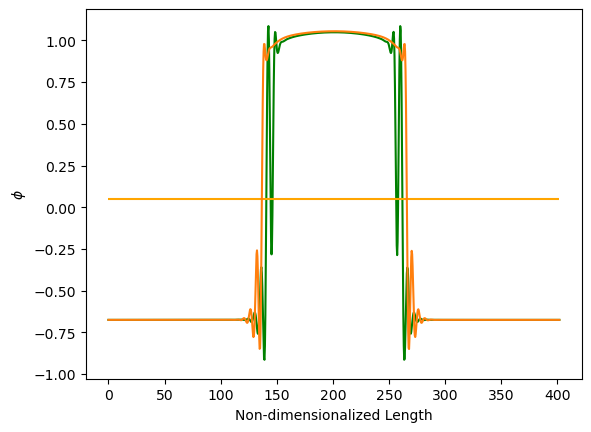

New Cell Time:  21.6
Growth Sim time:  674.0633647998329


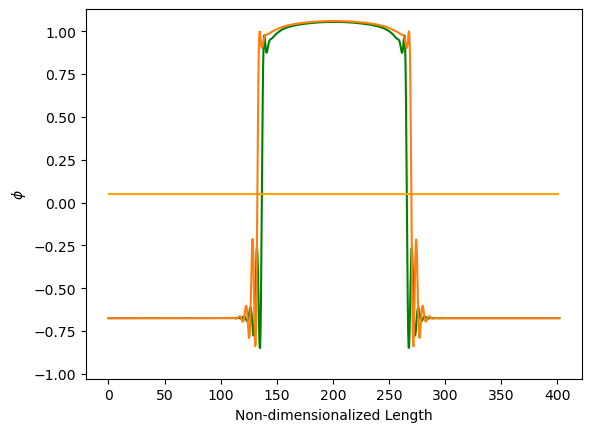

New Cell Time:  21.0
Growth Sim time:  688.053656199947


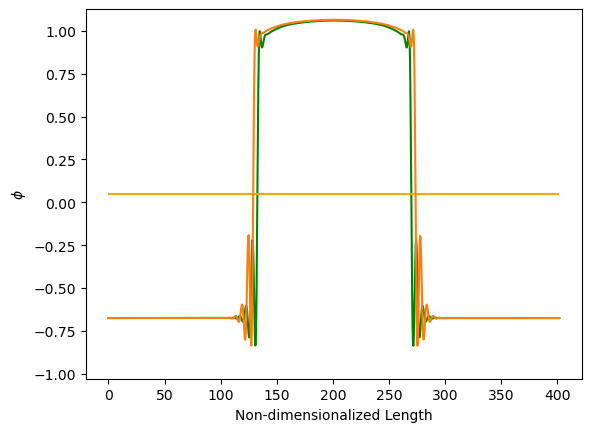

New Cell Time:  20.6
Growth Sim time:  681.1832457999699


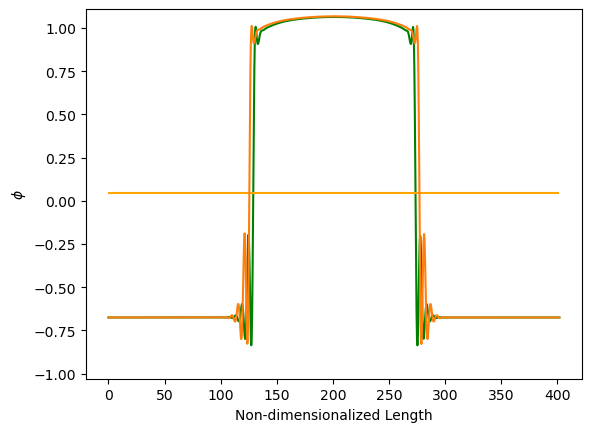

New Cell Time:  20.4
Growth Sim time:  692.5862634999212


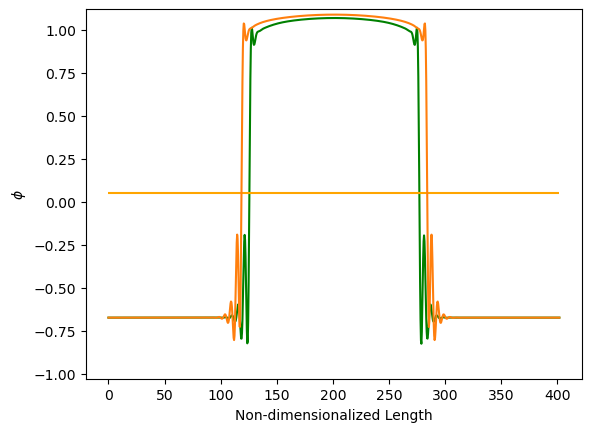

New Cell Time:  0.0
Growth Sim time:  652.7212256998755


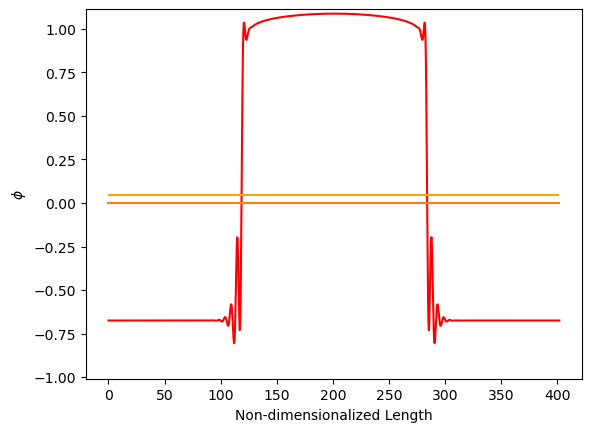

New Cell Time:  0.0
Growth Sim time:  543.327375800116


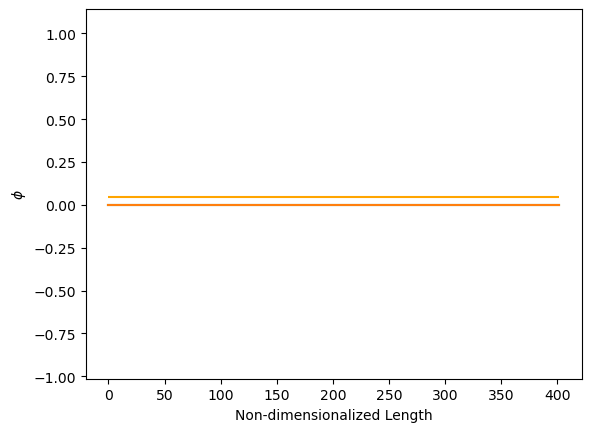

New Cell Time:  0.0
Growth Sim time:  278.9373852000572


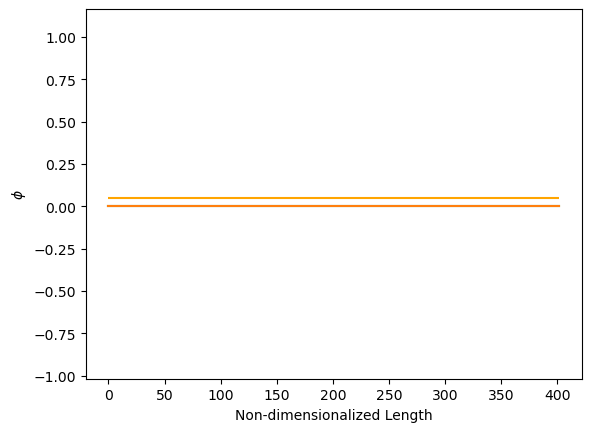

New Cell Time:  0.0


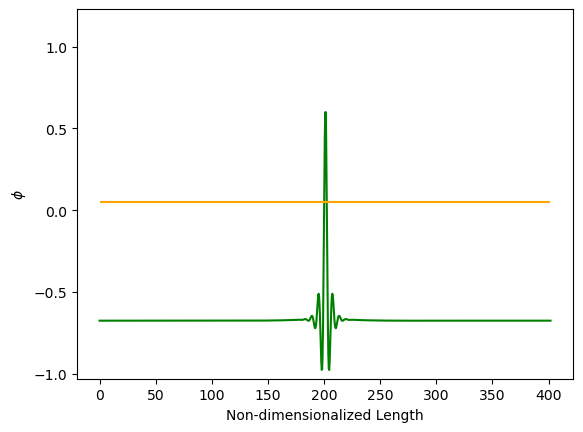

In [95]:
g_values = [0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 1] #np.linspace(0.02,0.08,num=4) #10.0**np.arange(-3,1,1)
total_steps_growth = 10000000
total_frames =  1000
single_cell_bool = True
single_cell_filename = r'Initialization States\steady single cell 1024.txt'


for g_val in g_values:
    full_evolution = np.zeros((total_frames, grid_points))
    all_g_values.append(g_val)
    c_growth_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update_growth.subs(M, mobility).subs(g,g_val).subs(S,sigmoid).subs(W,width).subs(C,center))]
                           ).compile()

    new_cell_times.append(cell_growth(start_from_single_cell=single_cell_bool)*time_discretization)
    print('New Cell Time: ', new_cell_times[-1])
    plt.show()
    fig,ax = plt.subplots()
    line, = ax.plot(domain_points,full_evolution[0])
    ax.set_ylim(np.min(full_evolution),np.max(full_evolution))
    plt.hlines(center-width/2,np.min(domain_points), np.max(domain_points), color='orange')
    plt.ylabel(r'$\phi$')
    plt.xlabel('Non-dimensionalized Length')
    
    
    anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

    anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\Growth\1D' + f' {grid_points} eps={epsilon} g={g_val} initphi={np.round(np.mean(full_evolution[0]),3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))



In [96]:

newcell_filename = r'New Cell Times\Growth vs. New Cells ' + f'{grid_points}.txt'
growth_and_cells = np.vstack((new_cell_times, all_g_values))
np.savetxt(newcell_filename, growth_and_cells)

In [97]:
growth_and_cells_256 = np.loadtxt(r'New Cell Times\Growth vs. New Cells 256.txt')
growth_and_cells_512 = np.loadtxt(r'New Cell Times\Growth vs. New Cells 512.txt')
growth_and_cells_1024 = np.loadtxt(r'New Cell Times\Growth vs. New Cells 1024.txt')
new_cell_times_256 = growth_and_cells_256[0]
all_g_values_256 = growth_and_cells_256[1]
new_cell_times_512 = growth_and_cells_512[0]
all_g_values_512 = growth_and_cells_512[1]
new_cell_times_1024 = growth_and_cells_1024[0]
all_g_values_1024 = growth_and_cells_1024[1]

In [113]:
new_cell_times_256=new_cell_times_256[:-4]
all_g_values_256=all_g_values_256[:-4]

In [114]:
new_cell_times_512=new_cell_times_512[1:-9]
all_g_values_512=all_g_values_512[1:-9],

In [115]:
new_cell_times_1024=new_cell_times_1024[1:-4] 
all_g_values_1024=all_g_values_1024[1:-4]

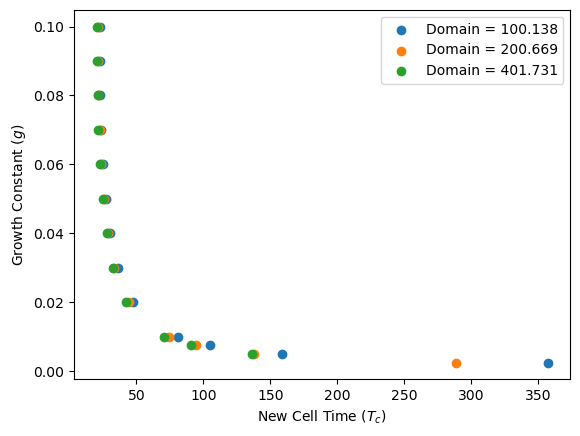

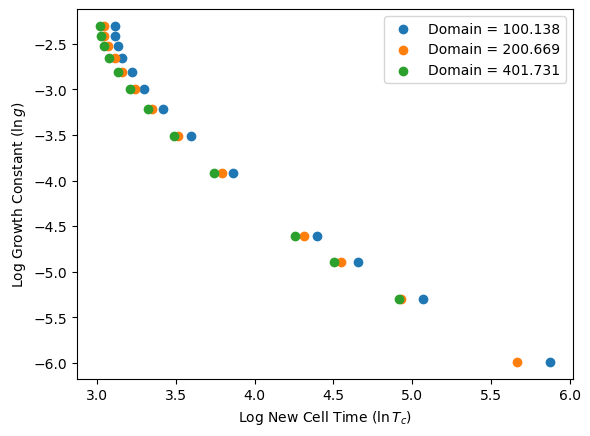

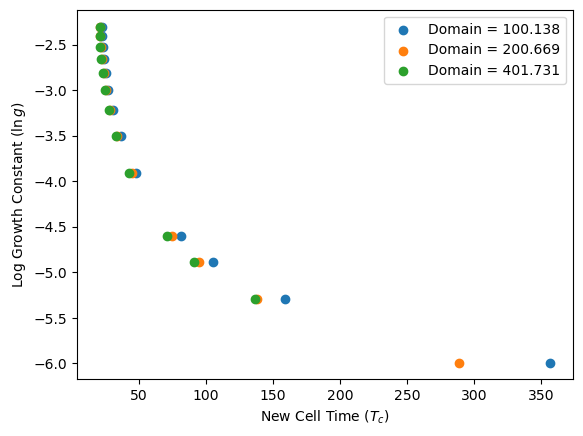

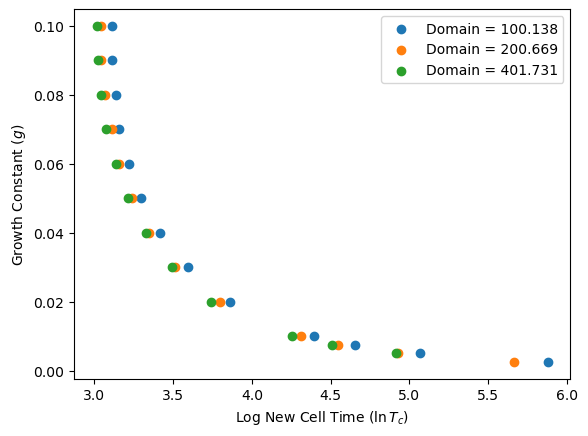

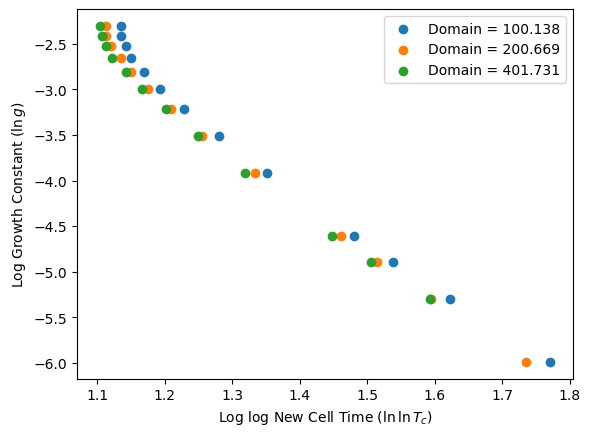

In [117]:
domain_256 = np.round(255*one_sixteenth_period,3)
domain_512 =np.round(511*one_sixteenth_period,3)
domain_1024 =np.round(1023*one_sixteenth_period,3)


# lin-lin
plt.scatter(new_cell_times_256, all_g_values_256, label = f'Domain = {domain_256}')
plt.scatter(new_cell_times_512, all_g_values_512, label = f'Domain = {domain_512}')
plt.scatter(new_cell_times_1024, all_g_values_1024, label = f'Domain = {domain_1024}')
plt.ylabel(r'Growth Constant ($g$)')
plt.xlabel(r'New Cell Time ($T_c$)')
plt.legend()
plt.savefig('growth vs. new cells.jpg', dpi=1200)
plt.show()

# log-log
plt.scatter(np.log(new_cell_times_256), np.log(all_g_values_256), label = f'Domain = {domain_256}')
plt.scatter(np.log(new_cell_times_512), np.log(all_g_values_512), label = f'Domain = {domain_512}')
plt.scatter(np.log(new_cell_times_1024), np.log(all_g_values_1024), label = f'Domain = {domain_1024}')
plt.ylabel(r'Log Growth Constant ($\ln g$)')
plt.xlabel(r'Log New Cell Time ($\ln T_c$)')
plt.legend()
plt.savefig('log-log growth vs. new cells.jpg', dpi=1200)
plt.show()

# lin-log
plt.scatter(new_cell_times_256, np.log(all_g_values_256), label = f'Domain = {domain_256}')
plt.scatter(new_cell_times_512, np.log(all_g_values_512), label = f'Domain = {domain_512}')
plt.scatter(new_cell_times_1024, np.log(all_g_values_1024), label = f'Domain = {domain_1024}')
plt.ylabel(r'Log Growth Constant ($\ln g$)')
plt.xlabel(r'New Cell Time ($T_c$)')
plt.legend()
plt.savefig('lin-log growth vs. new cells.jpg', dpi=1200)
plt.show()

#log-lin
plt.scatter(np.log(new_cell_times_256), all_g_values_256, label = f'Domain = {domain_256}')
plt.scatter(np.log(new_cell_times_512), all_g_values_512, label = f'Domain = {domain_512}')
plt.scatter(np.log(new_cell_times_1024), all_g_values_1024, label = f'Domain = {domain_1024}')
plt.ylabel(r'Growth Constant ($g$)')
plt.xlabel(r'Log New Cell Time ($\ln T_c$)')
plt.legend()
plt.savefig('log-lin growth vs. new cells.jpg', dpi=1200)
plt.show()


# log-loglog
plt.scatter(np.log(np.log(new_cell_times_256)), np.log(all_g_values_256), label = f'Domain = {domain_256}')
plt.scatter(np.log(np.log(new_cell_times_512)), np.log(all_g_values_512), label = f'Domain = {domain_512}')
plt.scatter(np.log(np.log(new_cell_times_1024)), np.log(all_g_values_1024), label = f'Domain = {domain_1024}')
plt.ylabel(r'Log Growth Constant ($\ln g$)')
plt.xlabel(r'Log log New Cell Time ($\ln\ln T_c$)')
plt.legend()
plt.savefig('log-loglog growth vs. new cells.jpg', dpi=1200)
plt.show()

In [108]:

myorder = [1, 2, 3, 0, 4, 5, 6]
new_cell_times = [new_cell_times[i] for i in myorder]
all_g_values = [all_g_values[i] for i in myorder]
new_cell_times, all_g_values

([81.30000000000001,
  58.50000000000001,
  47.7,
  27,
  16.900000000000002,
  5.500000000000001,
  2.24],
 [0.01, 0.015, 0.02, 0.05, 0.1, 0.3, 0.8])

In [32]:
all_g_values.pop(0)

0.0025

In [82]:
new_cell_times.pop(0)

0.0

In [31]:
new_cell_times, all_g_values

([357.00000000000006,
  159.0,
  105.00000000000001,
  81.0,
  47.50000000000001,
  36.5,
  30.500000000000004,
  27.000000000000004,
  25.000000000000004,
  23.500000000000004,
  23.000000000000004,
  22.500000000000004,
  22.500000000000004,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0025,
  0.0025,
  0.005,
  0.0075,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.06,
  0.07,
  0.08,
  0.09,
  0.1,
  0.2,
  0.3,
  0.4,
  1])

Cell length: 14
Initialized avg phi: -0.651376836992539
Sim time:  61.21594870000263
Sim time:  214.69827730000543


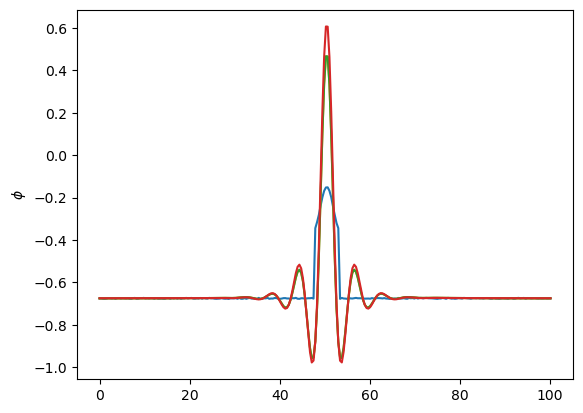

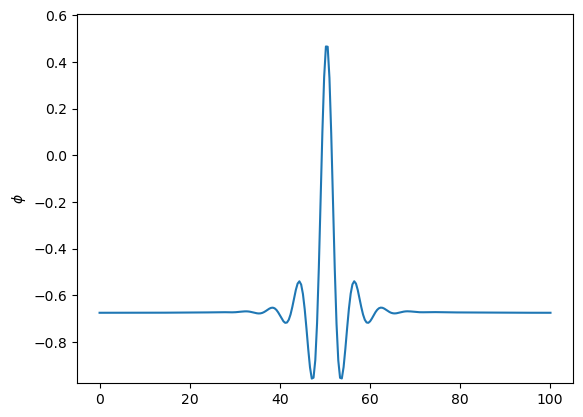

In [30]:
average_phi = -0.65
total_steps = 3000000
total_steps_growth = 5000000
total_frames =  1000
full_evolution = np.zeros((total_frames, grid_points))
single_cell_bool = True

cell_growth(start_from_single_cell=single_cell_bool)

fig,ax = plt.subplots()
line, = ax.plot(domain_points,full_evolution[0])
ax.set_ylim(np.min(full_evolution),np.max(full_evolution))
plt.ylabel(r'$\phi$')
    
anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\Growth\1D' + f' eps={epsilon} g={growth_factor} initphi={np.round(np.mean(full_evolution[0]),3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))


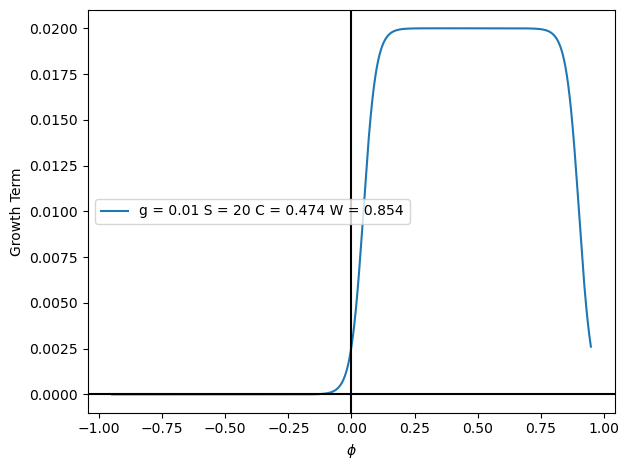

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import cmath as cm
%matplotlib inline

growth = lambda g,S,C,W,x: g*(np.tanh(S*(x-C+W/2))*np.tanh(S*(-x+C+W/2)) + 1)
growth_factor = 0.01
#Here we plot the form of the growth term

x_values_large = np.linspace(-np.sqrt(epsilon),np.sqrt(epsilon), 10000)

y_growth = growth(growth_factor,sigmoid,center,width, x_values_large)
plt.plot(x_values_large, y_growth, label = f'g = {growth_factor} S = {sigmoid} C = {np.round(center,3)} W = {np.round(width,3)}')
plt.xlabel(r'$\phi$')
plt.ylabel(r'Growth Term')
plt.legend()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.tight_layout()
plt.savefig(f'g={growth_factor}.jpg', dpi = 1200)
plt.show()

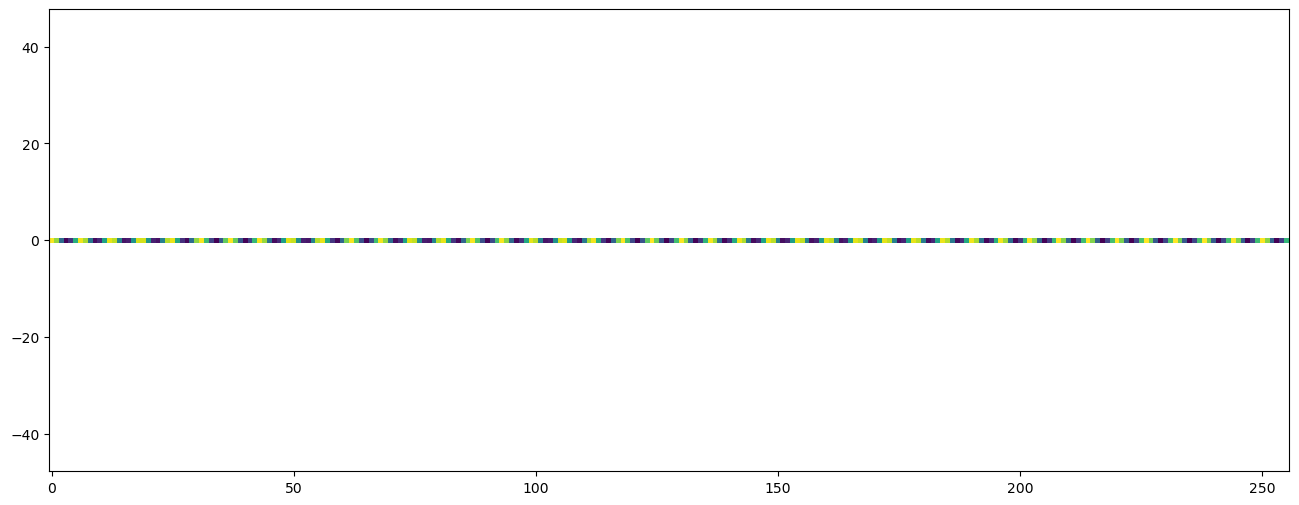

In [23]:
init(0,0.01) # initialize the system at time = 0
# run the simulation and save a video in time
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=2500)
writervideo = animation.FFMpegWriter(fps=60)
ani.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1Dswift-hohenberg.mp4', writer=writervideo)

# Let's figure out the 1D phase diagram

In [1]:
first_mode = lambda phi,r: 2*np.sqrt(-(r+3*phi**2)/3)/np.sqrt(1-(2*phi**2/3))
second_mode = lambda phi,r: -phi*first_mode(phi,r)**2/6

square_NRG_terms = lambda phi,r: 1/2*(r+1)*phi**2 + 1/4*r*first_mode(phi,r)**2 + 1/4*(r+9)*second_mode(phi,r)**2
quartic_NRG_terms = lambda phi,r: 1/4*phi**4 + 3/4*phi**2*(first_mode(phi,r)**2+second_mode(phi,r)**2) + 3/4*phi*first_mode(phi,r)**2*second_mode(phi,r) + 3/32*(first_mode(phi,r)**4+4*first_mode(phi,r)**2*second_mode(phi,r)**2+second_mode(phi,r)**4)

periodic_NRG_density = lambda phi,r: square_NRG_terms(phi,r) + quartic_NRG_terms(phi,r)

uniform_NRG_density = lambda phi,r: 1/2*(r+1)*phi**2+1/4*phi**4

test = lambda x,y: x + y

compound = lambda w,x,y,z: 0.5*w**4*test(x,y)**2 + z - w**2

w,x,y,z = (2,2,1,1)
compound(w,x,y,z)

69.0

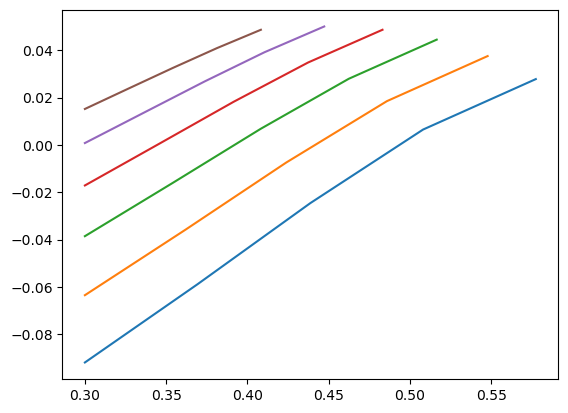

In [11]:

test_rs = np.linspace(-1,-0.5,6)
for r in test_rs:
    test_phis = np.linspace(0.3,np.sqrt(-r/3),5)
    plt.plot(test_phis,periodic_NRG_density(test_phis,r))

In [3]:
from scipy.optimize import minimize

uni_r_values = np.linspace(-1.1,-9/38,20)
uni_phi_values = []

for r in uni_r_values:
    result = minimize(uniform_NRG_density, -np.sqrt(4/38), args=(r), bounds=[(-0.78,-np.sqrt(3/38))])
    uni_phi_values.append(np.round(result.x,3)[0])

uni_phi_values

[-0.316,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281,
 -0.281]

In [73]:
from scipy.optimize import minimize

per_r_values = np.linspace(-1.1,-9/38,20)
per_phi_values = []

for r in uni_r_values:
    result = minimize(periodic_NRG_density, -np.sqrt(3/38)+0.01, args=(r), bounds=[(-np.sqrt(3/38),-0.21)])
    per_phi_values.append(np.round(result.x,3)[0])

per_phi_values

[-0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21,
 -0.21]

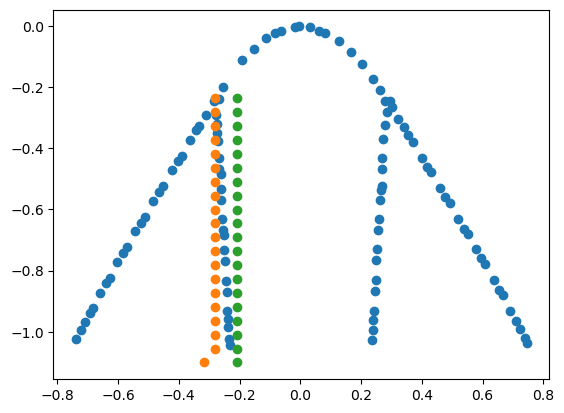

In [74]:
filename = r'Literature Data\1D Phase Diagrams Redlines Dataset.txt'
red_lines = np.loadtxt(filename)
plt.scatter(red_lines[:,0],red_lines[:,1])
plt.scatter(uni_phi_values,uni_r_values)
plt.scatter(per_phi_values,per_r_values)